In [36]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import PorterStemmer
from wordcloud import WordCloud
from nltk import sent_tokenize , word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score , precision_score
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Reading Dataset
name = ['sentiment' , 'ids' , 'date', 'flag' , 'user' , 'text']
df = pd.read_csv("Dataset/twitter.csv" , names= name)
# df = df[600000:1000000]
df.sample(5)

,sentiment,ids,date,flag,user,text
907980,4,1696004236,Mon May 04 07:24:45 PDT 2009,NO_QUERY,RichieRampage,"'If I don't believe in Him, why would He belie..."
1476545,4,2066117780,Sun Jun 07 09:55:21 PDT 2009,NO_QUERY,enterskyland,@smallbrownbird dont worry if ur not follow me...
309977,0,2001014806,Mon Jun 01 23:35:35 PDT 2009,NO_QUERY,jennasheehan,@victorzaa oh u didn knw check ur school email...
1175848,4,1981160827,Sun May 31 08:33:20 PDT 2009,NO_QUERY,MaleneTopp,Need Friends??
1537558,4,2179652291,Mon Jun 15 09:23:54 PDT 2009,NO_QUERY,arynfedie,Is getting ready to go to amy's house to do st...


In [38]:
# Replacing 4 --> 1 

df.info()
df.replace({'sentiment' : {4:1}} , inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


sentiment
0    800000
1    800000
Name: count, dtype: int64

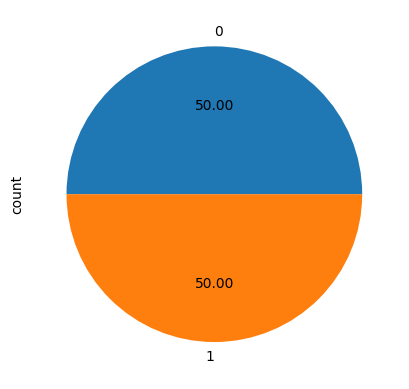

In [39]:
# Finding Sentiment count
df['sentiment'].value_counts().plot(kind = "pie" , autopct = '%.2f' )
df['sentiment'].value_counts()

In [40]:
df.isnull().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

In [41]:
df.duplicated().sum()
df = df.drop(columns= ['ids'])

In [42]:
df["charCount"] = df['text'].apply(len)
df["wordCount"] = df['text'].apply(lambda x : len(word_tokenize(x)))
df["sentCount"] = df['text'].apply(lambda x : len(sent_tokenize(x)))

<Axes: >

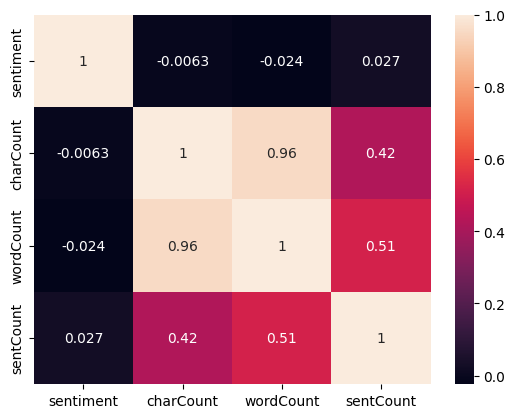

In [43]:
# No Conclusive edvidence that sentiment depends upon no of char
corr_matrix = df.select_dtypes('number').corr()
sns.heatmap(corr_matrix  , annot= True)

In [44]:
#  Making word cloud for most commmon postive and negative sentiment text

wc_pos = WordCloud(width = 600 , height = 600 , background_color = 'black' , min_font_size = 10 )
wc_neg = WordCloud(width = 600 , height = 600 , background_color = 'black' , min_font_size = 10 )

wc_negative = wc_neg.generate(df[df['sentiment'] == 0]['text'].str.cat(sep = ' '))
wc_positive = wc_pos.generate(df[df['sentiment'] == 1]['text'].str.cat(sep = ' '))

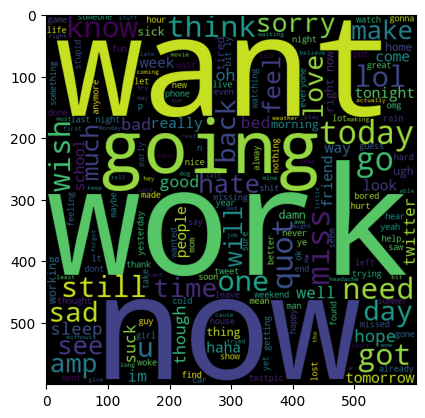

In [45]:
# Negative sentiment wordCloud
plt.imshow(wc_negative)

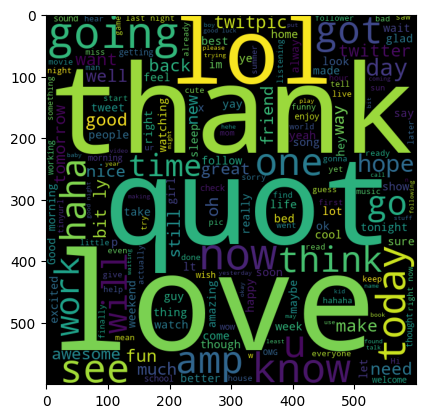

In [46]:
# Positive sentiment wordCloud
plt.imshow(wc_positive)

In [47]:
# Preprocssing of text data

df['text'] = df['text'].str.lower() # convert into lower-case

In [48]:
# Remove punctuation
exclude = string.punctuation 
def remove_pun(text):
    return text.translate(str.maketrans("" , '' , exclude))

df['text'] = df['text'].apply(remove_pun)

df['text'].iloc[:3]
    

0    switchfoot httptwitpiccom2y1zl  awww thats a b...
1    is upset that he cant update his facebook by t...
2    kenichan i dived many times for the ball manag...
Name: text, dtype: object

In [49]:
# Remove HTML tags using regular Expressions
def remove_html_tag(text):       
    pattern = re.compile("<.?>")
    return pattern.sub(r'' , text)

df['text'] = df['text'].apply(remove_html_tag)

df['text'].iloc[:3]

0    switchfoot httptwitpiccom2y1zl  awww thats a b...
1    is upset that he cant update his facebook by t...
2    kenichan i dived many times for the ball manag...
Name: text, dtype: object

In [50]:
# Remove Stop Words
stop_words = set(stopwords.words('english'))  

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words[:])

df['text'] = df['text'].apply(remove_stopwords)

df['text'].iloc[:3]


0    switchfoot httptwitpiccom2y1zl awww thats bumm...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save 50...
Name: text, dtype: object

In [51]:
# Convert each word into it's root word
ps = PorterStemmer()  

def stem(text):
    return " ".join([ps.stem(word) for word in text.split()])

df['text'] = df['text'].apply(stem)

df['text'].iloc[:3]

0    switchfoot httptwitpiccom2y1zl awww that bumme...
1    upset cant updat facebook text might cri resul...
2    kenichan dive mani time ball manag save 50 res...
Name: text, dtype: object

In [52]:
# Seperating data and label

X = df['text'].values
y = df['sentiment'].values

In [53]:
# Train test split of the data
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
print(X.shape , X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

(1600000,) (1280000,) (320000,)
(1280000,) (320000,)


In [54]:
# Vectorlization ( tf - Idf)

tf_idf = TfidfVectorizer()

X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)
print(X.shape , X_train.shape , X_test.shape)

(1600000,) (1280000, 669722) (320000, 669722)


In [55]:
AccuracyList = []
PrecisionList = []
Technique = []

In [56]:
# Training the Model ( LogisticRegression )

model = LogisticRegression(max_iter=1000)
model.fit(X_train , y_train)


LogisticRegression(max_iter=1000)

In [57]:
# accuracy score 

y_pred = model.predict(X_test)
print("The accuracy score for the Logistic Regression is:" , accuracy_score(y_test , y_pred))
Technique.append("TF - Idf")
PrecisionList.append(precision_score(y_test , y_pred))
AccuracyList.append(accuracy_score(y_test , y_pred))

The accuracy score for the Logistic Regression is: 0.783096875


Fine Tuning the Vectorization ( Bag of words )

In [58]:
# Train test split of the data
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
print(X.shape , X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

# Vectorlization ( Bag of Words )

bow = CountVectorizer() 

X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)
print(X.shape , X_train.shape , X_test.shape)

# Training the Model ( LogisticRegression )
model = LogisticRegression(max_iter=1000)
model.fit(X_train , y_train)

# accuracy score 
y_pred = model.predict(X_test)
print("The accuracy score for the Logistic Regression is:" , accuracy_score(y_test , y_pred))
Technique.append("Bag of Words")
PrecisionList.append(precision_score(y_test , y_pred))
AccuracyList.append(accuracy_score(y_test , y_pred))

(1600000,) (1280000,) (320000,)
(1280000,) (320000,)
(1600000,) (1280000, 669722) (320000, 669722)
The accuracy score for the Logistic Regression is: 0.78068125


Vectorization ( Bi-gram )

In [59]:
# Train test split of the data
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
print(X.shape , X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

# Vectorlization ( Bi-gram )

bi_gram = CountVectorizer(ngram_range=(2,2)) 

X_train = bi_gram.fit_transform(X_train)
X_test = bi_gram.transform(X_test)
print(X.shape , X_train.shape , X_test.shape)

# Training the Model ( LogisticRegression )
model = LogisticRegression(max_iter=1000)
model.fit(X_train , y_train)

# accuracy score 
y_pred = model.predict(X_test)
print("The accuracy score for the Logistic Regression is:" , accuracy_score(y_test , y_pred))
Technique.append("Bi - Gram")
PrecisionList.append(precision_score(y_test , y_pred))
AccuracyList.append(accuracy_score(y_test , y_pred))

(1600000,) (1280000,) (320000,)
(1280000,) (320000,)
(1600000,) (1280000, 3824312) (320000, 3824312)
The accuracy score for the Logistic Regression is: 0.739503125


Vectorization ( Bi-gram and Uni-gram )

In [60]:
# Train test split of the data
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
print(X.shape , X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

# Vectorlization ( Bi-gram and Uni-gram )

uni_bi_gram = CountVectorizer(ngram_range=(1,2) , max_features=1000000) 

X_train = uni_bi_gram.fit_transform(X_train)
X_test = uni_bi_gram.transform(X_test)
print(X.shape , X_train.shape , X_test.shape)

# Training the Model ( LogisticRegression )
model = LogisticRegression(max_iter=1000)

model.fit(X_train , y_train)
# accuracy score 
y_pred = model.predict(X_test)

print("The accuracy score for the Logistic Regression is:" , accuracy_score(y_test , y_pred))
Technique.append("Uni - Bi - Gram ")
PrecisionList.append(precision_score(y_test , y_pred))
AccuracyList.append(accuracy_score(y_test , y_pred))

(1600000,) (1280000,) (320000,)
(1280000,) (320000,)
(1600000,) (1280000, 1000000) (320000, 1000000)
The accuracy score for the Logistic Regression is: 0.793340625


Vectorization ( Tri-gram , Bi-gram and Uni-gram )

In [61]:
# Train test split of the data
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
print(X.shape , X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

# Vectorlization ( Tri-gram , Bi-gram and Uni-gram )

n_gram = CountVectorizer(ngram_range=(1,3) , max_features=1000000) 

X_train = n_gram.fit_transform(X_train)
X_test = n_gram.transform(X_test)
print(X.shape , X_train.shape , X_test.shape)

# Training the Model ( LogisticRegression )
model = LogisticRegression(max_iter=1000)
model.fit(X_train , y_train)

# accuracy score 
y_pred = model.predict(X_test)
print("The accuracy score for the Logistic Regression is:" , accuracy_score(y_test , y_pred))
Technique.append("Uni - Bi - Tri - Gram ")
PrecisionList.append(precision_score(y_test , y_pred))
AccuracyList.append(accuracy_score(y_test , y_pred))

(1600000,) (1280000,) (320000,)
(1280000,) (320000,)
(1600000,) (1280000, 1000000) (320000, 1000000)
The accuracy score for the Logistic Regression is: 0.7938875


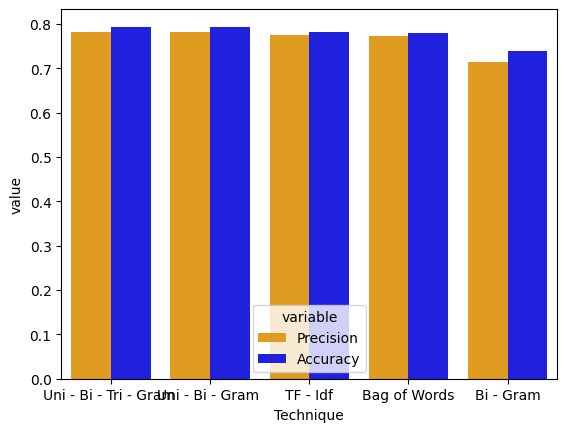

In [69]:

evaluation = pd.DataFrame({"Technique" : Technique , "Precision" : PrecisionList , "Accuracy" : AccuracyList} ).sort_values(by = "Accuracy" , ascending=False)

sns.barplot(x = "Technique" ,  y = "value" , hue = "variable",
            data = evaluation.melt(id_vars= "Technique") , palette=('orange' , 'blue'))
# plt.tight_layout()
plt.show()

In [71]:
import pickle

In [72]:
# Saving the best model using Pickle
filename = "N_Gram_LR_model.sav"
pickle.dump(model , open(filename , 'wb'))
pickle.dump(n_gram , open("Vectorizer.pkl" , 'wb'))

In [75]:
# Using the Saved model for Predction

loaded_model = pickle.load(open(filename , 'rb'))

y = loaded_model.predict(X_test)
print(precision_score(y_test , y))

0.7825441385985056
